<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_MH_Covid_Gto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import odeint

Cargamos los datos de incidencia durante 28 semanas.

In [ ]:
datos=pd.read_csv('201006COVID19MEXICO.csv', encoding='latin-1')
datos.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-10-06,02ab03,2,12,26,1,26,26,30,1,...,2,2,2,1,1,1,99,MÃ©xico,97,97
1,2020-10-06,11c483,1,12,29,1,29,29,33,1,...,2,2,2,2,1,1,99,MÃ©xico,97,97
2,2020-10-06,156b1d,1,9,9,1,9,9,4,1,...,2,2,1,1,1,1,99,MÃ©xico,97,97
3,2020-10-06,02d87b,2,12,2,2,2,2,2,1,...,2,2,2,1,1,1,99,MÃ©xico,97,97
4,2020-10-06,05f3d3,1,12,9,2,9,9,7,2,...,2,2,1,1,1,1,99,MÃ©xico,97,1


In [ ]:
for col in datos.columns:
    print(col)

FECHA_ACTUALIZACION
ID_REGISTRO
ORIGEN
SECTOR
ENTIDAD_UM
SEXO
ENTIDAD_NAC
ENTIDAD_RES
MUNICIPIO_RES
TIPO_PACIENTE
FECHA_INGRESO
FECHA_SINTOMAS
FECHA_DEF
INTUBADO
NEUMONIA
EDAD
NACIONALIDAD
EMBARAZO
HABLA_LENGUA_INDIG
DIABETES
EPOC
ASMA
INMUSUPR
HIPERTENSION
OTRA_COM
CARDIOVASCULAR
OBESIDAD
RENAL_CRONICA
TABAQUISMO
OTRO_CASO
TOMA_MUESTRA
RESULTADO
MIGRANTE
PAIS_NACIONALIDAD
PAIS_ORIGEN
UCI


Guanajuato es el estado #11.

In [ ]:
datos=pd.read_csv('201006COVID19MEXICO.csv',usecols=['FECHA_SINTOMAS','ENTIDAD_RES','RESULTADO'], encoding='latin-1')
print(datos.shape)
datos=datos[datos['ENTIDAD_RES']==11]
datos=datos[datos['RESULTADO']==1]

(2021255, 3)


In [ ]:
datos.shape

(42197, 3)

Lo anterior define los datos de interés.

In [3]:
#datos.to_csv("Covid19_GTO.csv")#Solo se hizo la primera vez para reducir el tamaño de la base.
datos=pd.read_csv('Covid19_GTO.csv')
datos.head()

,Unnamed: 0,ENTIDAD_RES,FECHA_SINTOMAS,RESULTADO
0,25,11,2020-03-14,1
1,47,11,2020-03-26,1
2,92,11,2020-03-24,1
3,189,11,2020-03-16,1
4,210,11,2020-03-20,1


Más tratamiento de los datos.

In [4]:
dia0=np.min(datos['FECHA_SINTOMAS'])
dia_f=np.max(datos['FECHA_SINTOMAS'])
print("Inicio de registro: ",dia0)
print("Final de registro: ",dia_f)
print("Numero de dias registrados: ",(pd.to_datetime(dia_f)-pd.to_datetime(dia0)).days)

Inicio de registro:  2020-03-10
Final de registro:  2020-10-05
Numero de dias registrados:  209


In [5]:
Num_semanas=int((pd.to_datetime(dia_f)-pd.to_datetime(dia0)).days/7)+1
vec_semanas=[str(pd.to_datetime(dia0) + pd.to_timedelta(7*i, unit='d'))[0:10] for i in range(0,Num_semanas+1)]
print(vec_semanas)
print(len(vec_semanas))

['2020-03-10', '2020-03-17', '2020-03-24', '2020-03-31', '2020-04-07', '2020-04-14', '2020-04-21', '2020-04-28', '2020-05-05', '2020-05-12', '2020-05-19', '2020-05-26', '2020-06-02', '2020-06-09', '2020-06-16', '2020-06-23', '2020-06-30', '2020-07-07', '2020-07-14', '2020-07-21', '2020-07-28', '2020-08-04', '2020-08-11', '2020-08-18', '2020-08-25', '2020-09-01', '2020-09-08', '2020-09-15', '2020-09-22', '2020-09-29', '2020-10-06']
31


In [212]:
Ydat=np.zeros(Num_semanas)
for fecha in datos['FECHA_SINTOMAS']:
    for k in range(1,len(Ydat)+1):#Esto se puede optimizar.
        if(fecha<vec_semanas[k] and fecha>=vec_semanas[k-1]):
            Ydat[k-1]+=1 
            break;

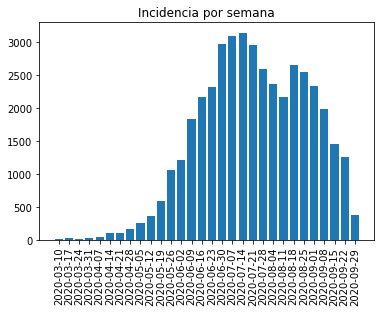

In [7]:
plt.bar(vec_semanas[0:-1],Ydat)
plt.xticks(rotation=90)
plt.title('Incidencia por semana')
plt.show()

Definimos la función del modelo SEIR que utilizaremos para ajustar los datos observados.

In [8]:
N=6e6
S0=N-1
I0=1
R0=0
X0=[S0,I0,1,R0]
INPUT=[S0,I0,1,R0]
def SIR(X,t, ps):
    try:
        be = ps['be'].value
        ga = ps['ga'].value
        N = ps['N'].value
    except:
        be,ga,N = ps  
    S,I,Y,R = X
    dS = -be*S*I/N
    dI = (be*S*I/N)- ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(4,)
    return(Xsol)
def SIR_izy(X,t, N, be,ga):#Para no tener problemas con los parametros de las funciones.
    S,I,Y,R = X
    dS = -be*S*I/N
    dI = be*S*I/N - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(4,)
    return(Xsol)

# Descripción

Función de verosimilitud de las observaciones. En este caso $f$ es la función de distribución posterior usando el modelo $Poisson$. La única razón para elegir una distribución Poisson es asegurarnos que los valores de la distribución sean enteras, pues estamos trabajando con número de personas.

Tenemos datos de incidencia de 31 semanas consecutivas.

In [9]:
#### verosimilitud
def logverosimilitud(theta):
    be,ga = theta
    semanas = 30
    t = np.linspace(0,30,31)  ## vector de tiempos
    Xt =  odeint(func=SIR_izy, y0=X0, t=t, args=(N,be,ga))
    ### Incidencia
    Inc = np.diff(Xt[:,2])#Valores de incidencia semanal.
    vers = scipy.stats.poisson.logpmf(Ydat, Inc)#Suponiendo que dado theta, los datos siguen distribucion 
            #Poisson de parámetro dado por el valor obtenido en la solución de la ODE
    ver = np.sum(vers)
    return(ver)
#### Posterior (Es más fácil trabajar con -log(Posterior))
def minuslogposterior(theta):
  return(-(logaprioris(theta)+logverosimilitud(theta)))


Usamos optimización numérica para conseguir una condición inicial de los parámetros y guiarnos para proponer las aprioris.

In [10]:
!pip install lmfit  #Solo correr una vez

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 32.9 MB/s 
     |████████████████████████████████| 98 kB 8.2 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=523f5df5257cdcb29be4c93570a56c0aaa55e8f9624886b55b15c6a18536af9a
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [11]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import scipy.integrate as spi
t_start = 0.0; 
t_end = 30; 
t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)
def g(t,ps):
    SOL = spi.odeint(SIR,INPUT,t_range,args=(ps,))
    return np.diff(SOL[:,2])
def residual(ps,ts,data):
    #INP =  ps['Y0'].value#Solo los infectados.
    model = g(ts,ps)
    return (model-data).ravel()
params = Parameters()
params.add('be', value=37.52425752, min=0, max=75)
params.add('ga', value=7, min=0, max=100)
params.add('N', value=float(N), min=N, max=N+1)
params.add('S0', value= float(N), min=0, max=N+1)
params.add('I0', value=float(1), min=0, max=1)
params.add('Y0', value=float(0), min=0, max=1)
t = np.linspace(0, 30, 31)
result = minimize(residual, params, args=(t, Ydat), method='leastsq',)

final = Ydat + result.residual.reshape(Ydat.shape)
result


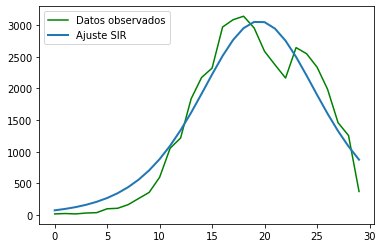

In [12]:
plt.plot(Ydat, '-g',label='Datos observados')
plt.plot(final, '-', linewidth=2,label='Ajuste SIR');
plt.legend()
plt.show()

In [13]:
be_0=result.params['be'].value
ga_0=result.params['ga'].value
x0=[be_0,ga_0]#Primer propuesta de la cadena en pytwalk()
print(x0)

[66.42179283230105, 66.16379011624164]


In [14]:
par1=[be_0,0,1]  #hiperparametros para beta
par2=[ga_0,0,1]  #hiperparametros para gamma

def logaprioris(theta):
    be,ga = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dga = scipy.stats.gamma.logpdf(ga,par2[0],par2[1],par2[2])
    return(dbe+dga)

Visualización de las distribuciones a prior. Utilizaremos distribuciones Gamma por simplicidad, pues satisfacen que su soporte es $(0,\infty)$, y podemos controlar el valor de su media fácilmente a través de sus parámetros.

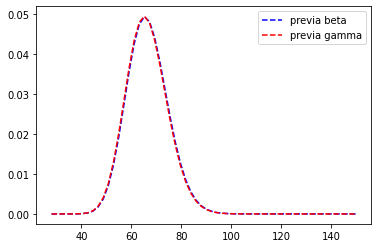

In [15]:
x = np.linspace(28., 150, 60)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
plt.plot(x, prev1, 'b--', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa gamma')
plt.legend(loc="best")

Buscamos numéricamente un mínimo local de la función de -log(Verosimilitud), para segunda propuesta de la cadena. 

# Metropolis Hastings

In [16]:
def logposterior(theta):
  return((logaprioris(theta)+logverosimilitud(theta)))

Función que calcula el ratio en el algoritmo MH. Para evitar errores numéricos, trabajamos con logaritmos.

In [17]:
def acceptance_probability(theta_new, theta_old):
    log_posterior_new = logposterior(theta_new)
    loh_posterior_old = logposterior(theta_old)
    ratio = np.exp(log_posterior_new-loh_posterior_old)
    return min(1, ratio)

A continuación, llevamos a cabo 100,000 iteraciones del algoritmo de MH, con el estado inicial dado por el ajute numérico descrito anteriormente.
Consideramos una distribución condicional (para generar las propuestas) de tipo normal. Dado que nuestra cadena inicia en valores muy grandes, no hay problema con que las propuestas de distribución $Normal(theta_{-1},sd)$ sean negativas. Consideramos $sd=0.25$ para mantener los valores propuestos cercanos a la propuesta inicial.

In [117]:
iters=100000
np.random.seed(1)
beta_samp=np.zeros(iters)
gamma_samp=np.zeros(iters)
beta_samp[0]=be_0
gamma_samp[0]=ga_0
iteration=0
acept=0
for i in range(1,iters):
    beta_curr=beta_samp[i-1]
    gamma_curr=gamma_samp[i-1]
    beta_prop=beta_curr+np.random.normal(0,0.25)
    gamma_prop=gamma_curr+np.random.normal(0,0.25)
    A=acceptance_probability([beta_prop,gamma_prop], [beta_curr,gamma_curr])
    if np.random.uniform(0,1,1)<A:
        beta_samp[i]=beta_prop
        gamma_samp[i]=gamma_prop
        iteration=iteration+1
        acept+=1
    else:
        beta_samp[i]=beta_samp[i-1]
        gamma_samp[i]=gamma_samp[i-1]
        iteration=iteration+1
eff=(acept/iteration)*100#


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


Recordemos que MH es un algoritmo de Acepta-Rechaza, por lo que podemos ver el número de veces que aceptó una propuesta:

In [130]:
beta_samps=beta_samp
gamma_samps=gamma_samp
print(r"% de aceptados: ", str(np.round(eff))+r'%')

% de aceptados:  43.0%


Graficamos las cadenas obtenidas por el algoritmo.

<Figure size 432x288 with 0 Axes>

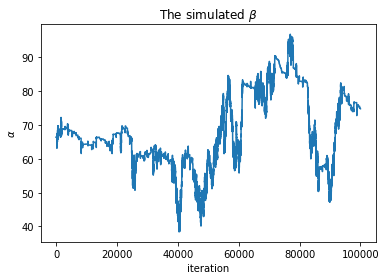

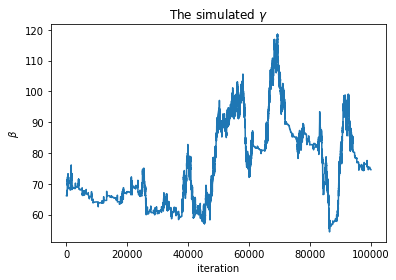

<Figure size 432x288 with 0 Axes>

In [131]:
iterr=np.linspace(1,iters,iters)
plt.plot(iterr[1:iters], beta_samps[1:iters])
plt.xlabel('iteration')
# naming the y axis
plt.ylabel(r'$\alpha$')
# giving a title to my graph 
plt.title(r'The simulated $\beta$')
plt.figure()

plt.plot(iterr[1:iters], gamma_samps[1:iters])
plt.xlabel('iteration') 
# naming the y axis
plt.ylabel(r'$\beta$') 
# giving a title to my graph 
plt.title(r'The simulated $\gamma$')
plt.figure()

# Calentamiento y adelgazamiento.
Consideraremos $\%15$ de la cadena como calentamiento y la desechamos.

In [132]:
burn=int(np.floor(.15*iters))
beta_samps=beta_samps[burn:]
gamma_samps=gamma_samps[burn:]

A falta de una funcion como IAT() en pytwalk, haremos el adelgazamiento usando inspección.

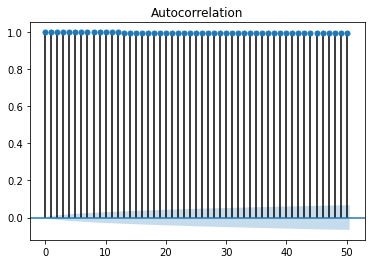

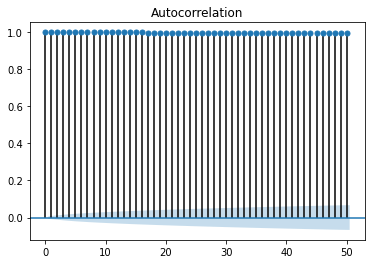

In [133]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(beta_samps.tolist(), lags=50);
plot_acf(gamma_samps.tolist(), lags=50);

Como vemos, tiene una autocorrelación muy alta.
Consideramos adelgazamiento de $\tau=50,100,150$ para comparar.

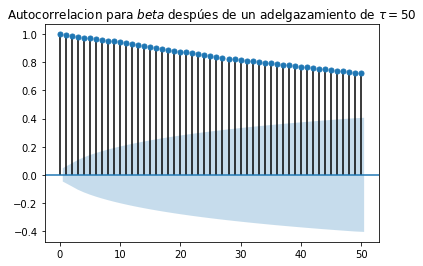

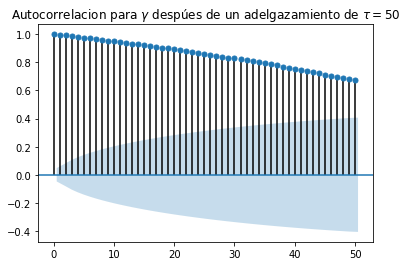

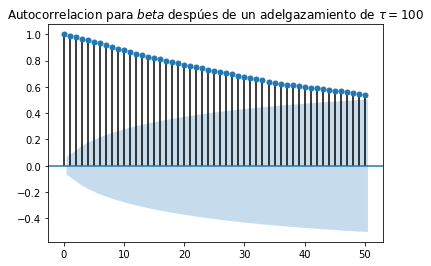

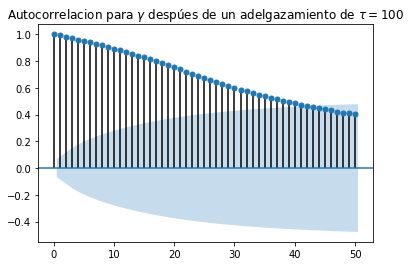

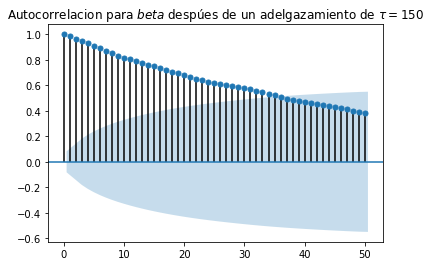

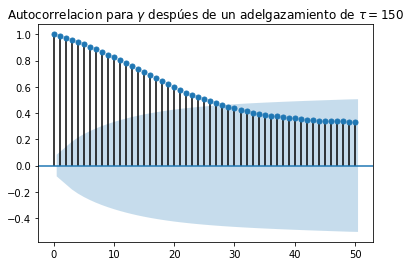

In [134]:
for tau in [50,100,150]:
    plot_acf(beta_samps[np.arange(0,len(beta_samps),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $beta$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()
    plot_acf(gamma_samps[np.arange(0,len(beta_samps),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $\gamma$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()

Se ven valores más pequeños para $\tau=150$, así que nos quedamos con ese periodo.

In [135]:
tau=150
beta_samps=beta_samps[np.arange(0,len(beta_samps),step=tau)]
gamma_samps=gamma_samps[np.arange(0,len(gamma_samps),step=tau)]

Ya con nuestra subcadena, graficamos los histogramas de los valores de los parámetros obtenidos.

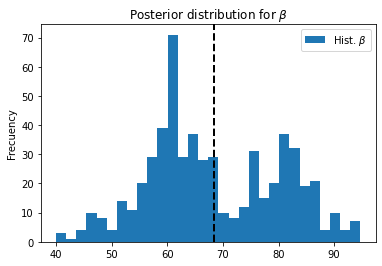

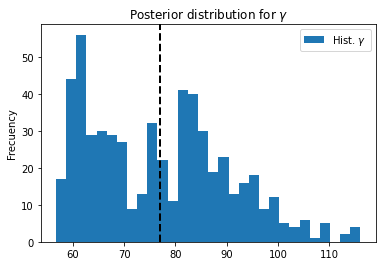

In [136]:
plt.hist(beta_samps,bins=30,density=False,label=r'Hist. $\beta$')
plt.axvline(beta_samps.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\beta$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()
plt.hist(gamma_samps,bins=30,density=False,label=r'Hist. $\gamma$')
plt.axvline(gamma_samps.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\gamma$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()

Por último, calculamos intervalos del $\%95$ (incluímos la mediana como referencia).

In [141]:
from scipy.stats.mstats import mquantiles
quant_b_95=np.array(mquantiles(beta_samps, prob=[0.025, 0.975]))
quant_g_95=mquantiles(gamma_samps, prob=[0.025, 0.975])
print("Beta:   ",quant_b_95 )
print("Gamma:  ",quant_g_95)

Beta:    [46.85574476 65.58377209 90.397063  ]
Gamma:   [ 57.91482106  76.39290523 105.30936475]


In [ ]:
beta_samps=beta_samp
gamma_samps=gamma_samp
print(r"% de aceptados: ", str(np.round(eff))+r'%')

% de aceptados:  43.0%


<Figure size 432x288 with 0 Axes>

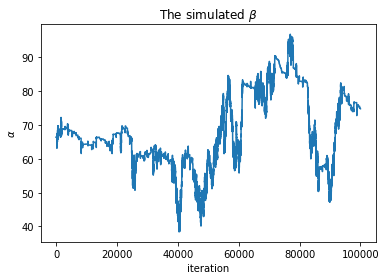

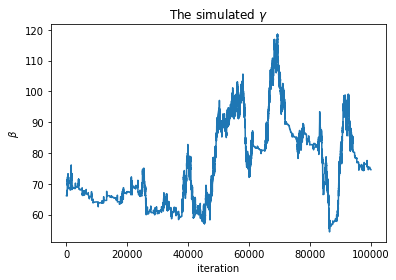

<Figure size 432x288 with 0 Axes>

In [ ]:
iterr=np.linspace(1,iters,iters)
plt.plot(iterr[1:iters], beta_samps[1:iters])
plt.xlabel('iteration')
# naming the y axis
plt.ylabel(r'$\alpha$')
# giving a title to my graph 
plt.title(r'The simulated $\beta$')
plt.figure()

plt.plot(iterr[1:iters], gamma_samps[1:iters])
plt.xlabel('iteration') 
# naming the y axis
plt.ylabel(r'$\beta$') 
# giving a title to my graph 
plt.title(r'The simulated $\gamma$')
plt.figure()

In [ ]:
burn=int(np.floor(.15*iters))
beta_samps=beta_samps[burn:]
gamma_samps=gamma_samps[burn:]

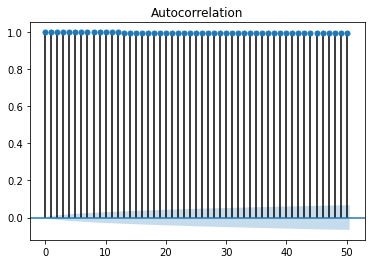

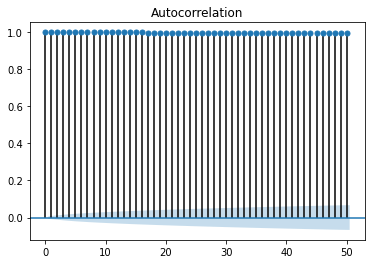

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(beta_samps.tolist(), lags=50);
plot_acf(gamma_samps.tolist(), lags=50);

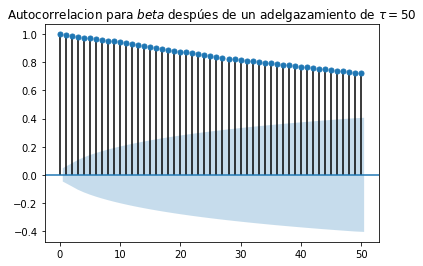

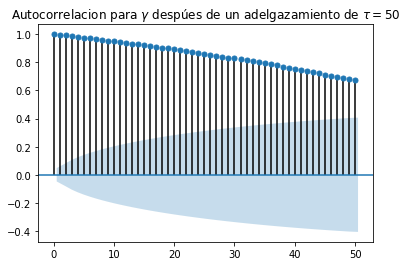

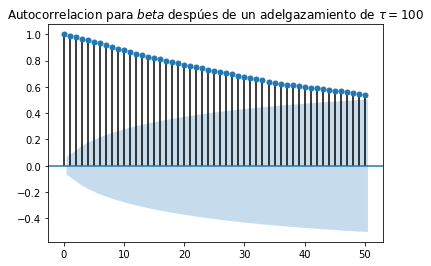

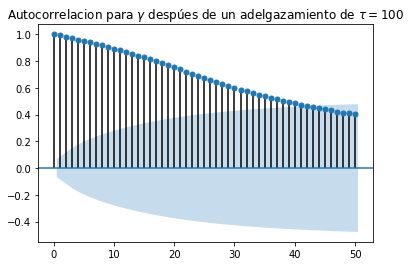

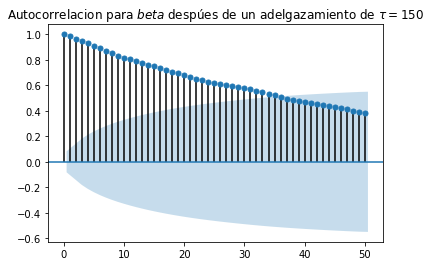

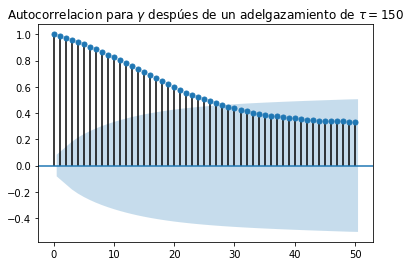

In [ ]:
for tau in [50,100,150]:
    plot_acf(beta_samps[np.arange(0,len(beta_samps),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $beta$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()
    plot_acf(gamma_samps[np.arange(0,len(beta_samps),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $\gamma$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()

In [ ]:
tau=150
beta_samps=beta_samps[np.arange(0,len(beta_samps),step=tau)]
gamma_samps=gamma_samps[np.arange(0,len(gamma_samps),step=tau)]

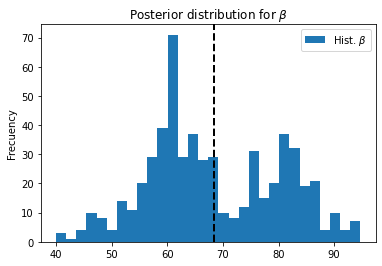

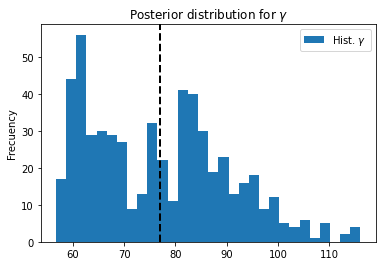

In [ ]:
plt.hist(beta_samps,bins=30,density=False,label=r'Hist. $\beta$')
plt.axvline(beta_samps.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\beta$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()
plt.hist(gamma_samps,bins=30,density=False,label=r'Hist. $\gamma$')
plt.axvline(gamma_samps.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\gamma$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()

In [ ]:
from scipy.stats.mstats import mquantiles
quant_b_95=np.array(mquantiles(beta_samps, prob=[0.025, 0.975]))
quant_g_95=mquantiles(gamma_samps, prob=[0.025, 0.975])
print("Beta:   ",quant_b_95 )
print("Gamma:  ",quant_g_95)

Beta:    [46.85574476 65.58377209 90.397063  ]
Gamma:   [ 57.91482106  76.39290523 105.30936475]


# Nota.
Notemos que los extremos de los intervalos satisfacen que $\beta>\gamma$, y recordemos que estos son parámetros de un modelo SIR, por lo que una relación de orden entre estos parámetros son condición suficiente y necesaria para tener una epidemio y no sólo un brote. En específico, requerimos que $$\mathcal{R}_0:=\beta/\gamma >1$$. 
Si esto no ocurre, no hay epidemia.

En tal caso, me gustaría añadir esta condición al algoritmo de MH de manera que las propuestas satisfagan esta relación. Naturalmente, esto disminuirá la Aceptación del algoritmo (anteriormente del $\%43$).

Consideramos 20,000 iteraciones y la misma distribución como generadora de propuestas.

In [177]:
iters=20000
np.random.seed(1)
beta_samp2=np.zeros(iters)
gamma_samp2=np.zeros(iters)
beta_samp2[0]=be_0
gamma_samp2[0]=ga_0
iteration=0
acept=0
for i in range(1,iters):
    beta_curr=beta_samp2[i-1]
    gamma_curr=gamma_samp2[i-1]
    beta_prop=beta_curr+np.random.normal(0,0.25)
    gamma_prop=gamma_curr+np.random.normal(0,0.25)
    A=acceptance_probability([beta_prop,gamma_prop], [beta_curr,gamma_curr])
    if np.random.uniform(0,1,1)<A and beta_prop>gamma_prop:
        beta_samp2[i]=beta_prop
        gamma_samp2[i]=gamma_prop
        iteration=iteration+1
        acept+=1
    else:
        beta_samp2[i]=beta_samp[i-1]
        gamma_samp2[i]=gamma_samp[i-1]
        iteration=iteration+1
eff=(acept/iteration)*100#


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [178]:
beta_samps2=beta_samp2
gamma_samps2=gamma_samp2
print(r"% de aceptados: ", str(np.round(eff))+r'%')

% de aceptados:  1.0%


Ahora, nuestra aceptación bajó muchísimo ($\%1$), pero ahora nuestros parámetros tienen sentido biológico respecto a lo que observamos de los datos.

Hacemos el mismo procedimiento de calentamiento y adelgazamiento.

<Figure size 432x288 with 0 Axes>

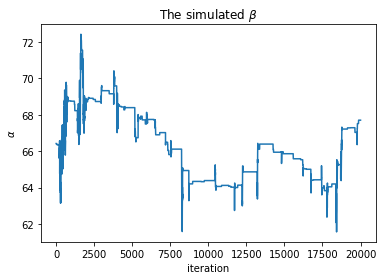

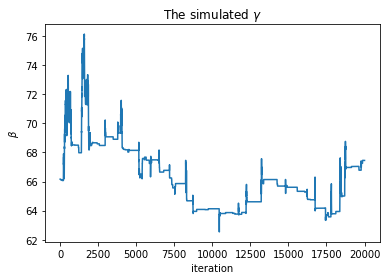

<Figure size 432x288 with 0 Axes>

In [179]:
iterr=np.linspace(1,iters,iters)
plt.plot(iterr[1:iters], beta_samps2[1:iters])
plt.xlabel('iteration')
# naming the y axis
plt.ylabel(r'$\alpha$')
# giving a title to my graph 
plt.title(r'The simulated $\beta$')
plt.figure()

plt.plot(iterr[1:iters], gamma_samps2[1:iters])
plt.xlabel('iteration') 
# naming the y axis
plt.ylabel(r'$\beta$') 
# giving a title to my graph 
plt.title(r'The simulated $\gamma$')
plt.figure()

In [180]:
burn=int(np.floor(.10*iters))
beta_samps2=beta_samps2[burn:]
gamma_samps2=gamma_samps2[burn:]

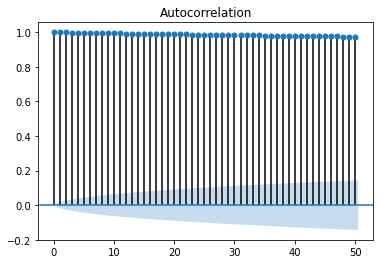

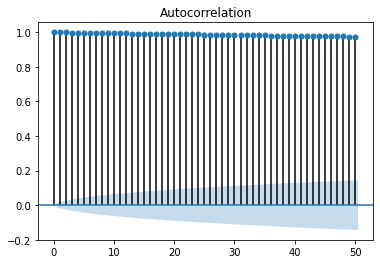

In [181]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(beta_samps2.tolist(), lags=50);
plot_acf(gamma_samps2.tolist(), lags=50);

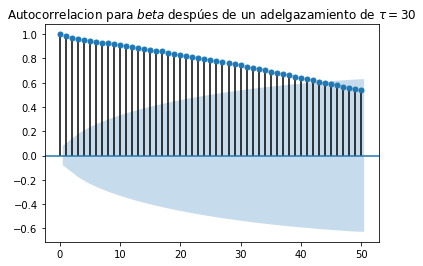

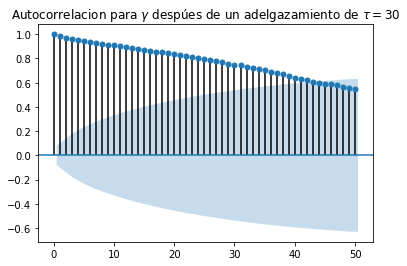

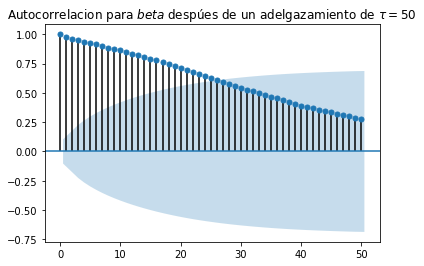

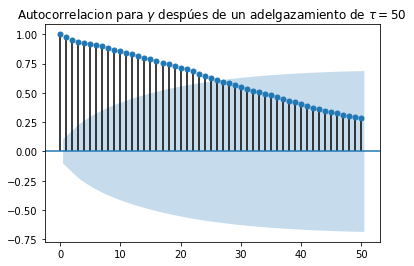

In [183]:
for tau in [30,50]:
    plot_acf(beta_samps2[np.arange(0,len(beta_samps2),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $beta$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()
    plot_acf(gamma_samps2[np.arange(0,len(beta_samps2),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $\gamma$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()

In [184]:
tau=50
beta_samps2=beta_samps2[np.arange(0,len(beta_samps2),step=tau)]
gamma_samps2=gamma_samps2[np.arange(0,len(gamma_samps2),step=tau)]

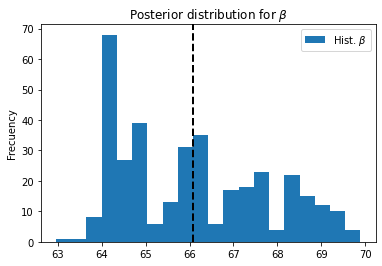

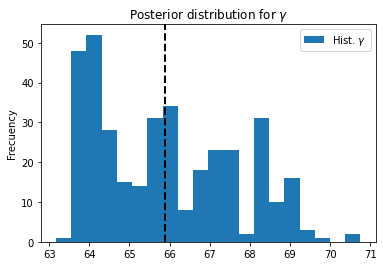

In [185]:
plt.hist(beta_samps2,bins=20,density=False,label=r'Hist. $\beta$')
plt.axvline(beta_samps2.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\beta$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()
plt.hist(gamma_samps2,bins=20,density=False,label=r'Hist. $\gamma$')
plt.axvline(gamma_samps2.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\gamma$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()

Ahora, calculamos los intervalos del $\%95$ y se espera que se conserven las relaciones de orden.

In [188]:
from scipy.stats.mstats import mquantiles
quant_b2_95=np.array(mquantiles(beta_samps2, prob=[0.025, 0.5,0.975]))
quant_g2_95=mquantiles(gamma_samps2, prob=[0.025,0.5, 0.975])
print("Beta:   ",quant_b2_95 )
print("Gamma:  ",quant_g2_95)

Beta:    [63.9914172  65.91615044 69.32835071]
Gamma:   [63.75087436 65.68850731 69.07134106]


Como vemos, se satisface que $\beta>\gamma$ (los quantiles).

Y por lo tanto, si consideramos estos parámetros en nuestro modelo SIR, habrá una dinámica no trivial, como se deseaba.
Graficamos el número de incidencias en cada elección de par de parámetros.

In [207]:
estimadores=np.matrix(np.array([quant_b2_95,quant_g2_95])).T
estimadores

matrix([[63.9914172 , 63.75087436],
        [65.91615044, 65.68850731],
        [69.32835071, 69.07134106]])

[[63.9914172  63.75087436]]
[[65.91615044 65.68850731]]
[[69.32835071 69.07134106]]


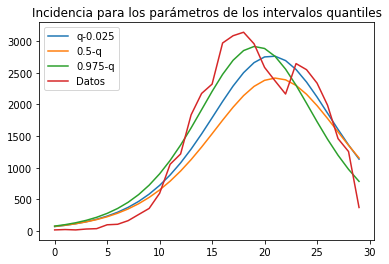

In [209]:
etiquetas=["q-0.025","0.5-q","0.975-q"]
for i in range(3):
    print(estimadores[i])
    def g(t,ps):
        SOL = spi.odeint(SIR,[6e6-1,1,1,0],t_range,args=(ps,))
        return np.diff(SOL[:,2])
    plt.plot(g(np.arange(0,31,500),[estimadores[i,0],estimadores[i,1],6e6]),label=etiquetas[i])
plt.plot(Ydat,label='Datos')
plt.title('Incidencia para los parámetros de los intervalos quantiles')
plt.legend()
plt.show()

Como vemos, tiene sentido biológico y además ajusta muy bien a los datos.

# Ejercicio de Predicción.

Repetiremos el procedimiento para un subconjunto de los datos (hasta una fecha fija), y se harán predicciones sobre el número de incidencias en las próximas 2 semanas, a fin de verificar si coincide con el número observado.

Nos interesan los datos hasta el 30/04/2020.

In [210]:
print(vec_semanas)

['2020-03-10', '2020-03-17', '2020-03-24', '2020-03-31', '2020-04-07', '2020-04-14', '2020-04-21', '2020-04-28', '2020-05-05', '2020-05-12', '2020-05-19', '2020-05-26', '2020-06-02', '2020-06-09', '2020-06-16', '2020-06-23', '2020-06-30', '2020-07-07', '2020-07-14', '2020-07-21', '2020-07-28', '2020-08-04', '2020-08-11', '2020-08-18', '2020-08-25', '2020-09-01', '2020-09-08', '2020-09-15', '2020-09-22', '2020-09-29', '2020-10-06']


Identificamos que se trata de la semana 8.

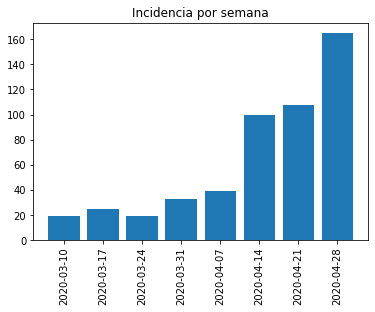

In [213]:
Ydat=Ydat[:8]
plt.bar(vec_semanas[0:8],Ydat)
plt.xticks(rotation=90)
plt.title('Incidencia por semana')
plt.show()

In [214]:
#### verosimilitud
def logverosimilitud(theta):
    be,ga = theta
    semanas = 8
    t = np.linspace(0,8,9)  ## vector de tiempos
    Xt =  odeint(func=SIR_izy, y0=X0, t=t, args=(N,be,ga))
    ### Incidencia
    Inc = np.diff(Xt[:,2])#Valores de incidencia semanal.
    vers = scipy.stats.poisson.logpmf(Ydat, Inc)#Suponiendo que dado theta, los datos siguen distribucion 
            #Poisson de parámetro dado por el valor obtenido en la solución de la ODE
    ver = np.sum(vers)
    return(ver)
#### Posterior (Es más fácil trabajar con -log(Posterior))
def minuslogposterior(theta):
  return(-(logaprioris(theta)+logverosimilitud(theta)))


In [216]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import scipy.integrate as spi
t_start = 0.0; 
t_end = 8; 
t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)
def g(t,ps):
    SOL = spi.odeint(SIR,INPUT,t_range,args=(ps,))
    return np.diff(SOL[:,2])
def residual(ps,ts,data):
    #INP =  ps['Y0'].value#Solo los infectados.
    model = g(ts,ps)
    return (model-data).ravel()
params = Parameters()
params.add('be', value=37.52425752, min=0, max=75)
params.add('ga', value=7, min=0, max=100)
params.add('N', value=float(N), min=N, max=N+1)
params.add('S0', value= float(N), min=0, max=N+1)
params.add('I0', value=float(1), min=0, max=1)
params.add('Y0', value=float(0), min=0, max=1)
t = np.linspace(0, 8, 31)
result = minimize(residual, params, args=(t, Ydat), method='leastsq',)

final = Ydat + result.residual.reshape(Ydat.shape)
result


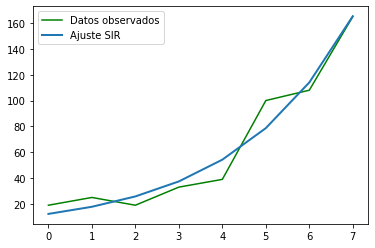

In [217]:
plt.plot(Ydat, '-g',label='Datos observados')
plt.plot(final, '-', linewidth=2,label='Ajuste SIR');
plt.legend()
plt.show()

In [218]:
be_0=result.params['be'].value
ga_0=result.params['ga'].value
x0=[be_0,ga_0]#Primer propuesta de la cadena en pytwalk()
print(x0)

[10.131765687643467, 9.760093085450633]


In [219]:
par1=[be_0,0,1]  #hiperparametros para beta
par2=[ga_0,0,1]  #hiperparametros para gamma

def logaprioris(theta):
    be,ga = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dga = scipy.stats.gamma.logpdf(ga,par2[0],par2[1],par2[2])
    return(dbe+dga)

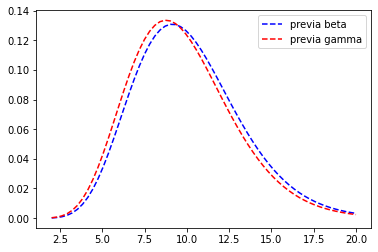

In [221]:
x = np.linspace(2., 20, 60)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
plt.plot(x, prev1, 'b--', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa gamma')
plt.legend(loc="best")

In [245]:
iters=40000
np.random.seed(1)
beta_samp3=np.zeros(iters)
gamma_samp3=np.zeros(iters)
beta_samp3[0]=be_0
gamma_samp3[0]=ga_0
iteration=0
acept=0
for i in range(1,iters):
    beta_curr=beta_samp3[i-1]
    gamma_curr=gamma_samp3[i-1]
    beta_prop=beta_curr+np.random.normal(0,0.25)
    gamma_prop=gamma_curr+np.random.normal(0,0.25)
    A=acceptance_probability([beta_prop,gamma_prop], [beta_curr,gamma_curr])
    if np.random.uniform(0,1,1)<A and beta_prop>gamma_prop:
        beta_samp3[i]=beta_prop
        gamma_samp3[i]=gamma_prop
        iteration=iteration+1
        acept+=1
    else:
        beta_samp3[i]=beta_samp3[i-1]
        gamma_samp3[i]=gamma_samp3[i-1]
        iteration=iteration+1
eff=(acept/iteration)*100#

In [246]:
beta_samps3=beta_samp3
gamma_samps3=gamma_samp3
print(r"% de aceptados: ", str(np.round(eff))+r'%')

% de aceptados:  3.0%


In [247]:
burn=int(np.floor(.15*iters))
beta_samps3=beta_samps3[burn:]
gamma_samps3=gamma_samps3[burn:]

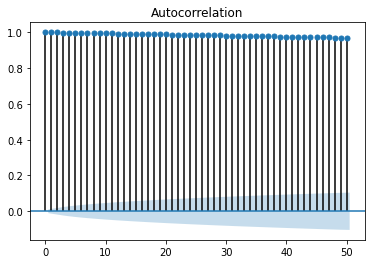

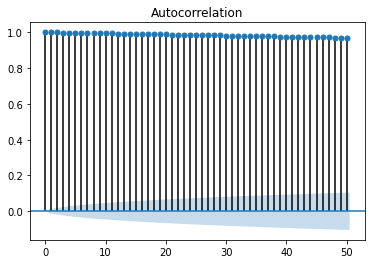

In [248]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(beta_samps3.tolist(), lags=50);
plot_acf(gamma_samps3.tolist(), lags=50);

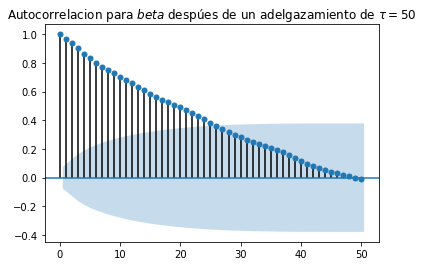

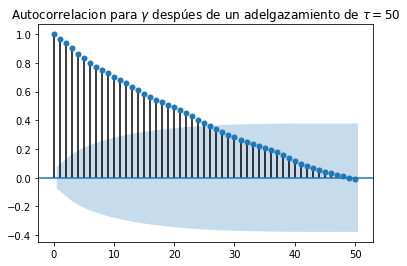

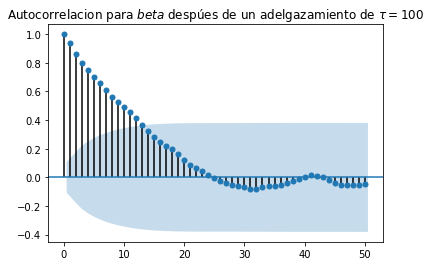

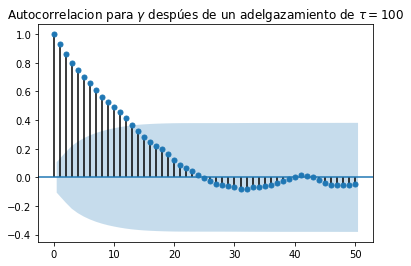

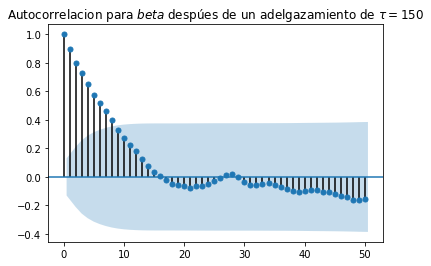

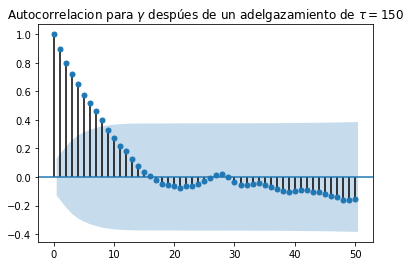

In [249]:
for tau in [50,100,150]:
    plot_acf(beta_samps3[np.arange(0,len(beta_samps3),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $beta$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()
    plot_acf(gamma_samps3[np.arange(0,len(beta_samps3),step=tau)].tolist(), lags=50);
    plt.title(r"Autocorrelacion para $\gamma$ despúes de un adelgazamiento de $\tau=$"+str(tau))
    plt.show()

In [250]:
tau=100
beta_samps3=beta_samps3[np.arange(0,len(beta_samps3),step=tau)]
gamma_samps3=gamma_samps3[np.arange(0,len(gamma_samps3),step=tau)]

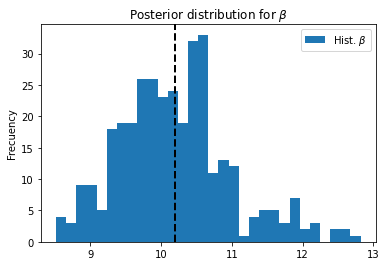

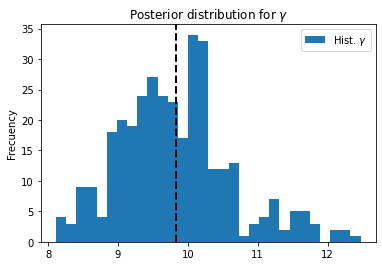

In [251]:
plt.hist(beta_samps3,bins=30,density=False,label=r'Hist. $\beta$')
plt.axvline(beta_samps3.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\beta$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()
plt.hist(gamma_samps3,bins=30,density=False,label=r'Hist. $\gamma$')
plt.axvline(gamma_samps3.mean(), color='k', linestyle='dashed', linewidth=2)
plt.title(r"Posterior distribution for $\gamma$")
plt.ylabel("Frecuency")
plt.legend()
plt.show()

In [253]:
from scipy.stats.mstats import mquantiles
quant_b3_95=np.array(mquantiles(beta_samps3, prob=[0.025,0.5, 0.975]))
quant_g3_95=mquantiles(gamma_samps3, prob=[0.025 ,0.5,0.975])
print("Beta:   ",quant_b3_95 )
print("Gamma:  ",quant_g3_95)

Beta:    [ 8.85359667 10.13667481 12.03904544]
Gamma:   [ 8.46053283  9.76162744 11.70456763]


Graficamos las incidencias correspondientes a estos valores de los parámetros

In [255]:
estimadores=np.matrix(np.array([quant_b3_95,quant_g3_95])).T
estimadores

matrix([[ 8.85359667,  8.46053283],
        [10.13667481,  9.76162744],
        [12.03904544, 11.70456763]])

[[8.85359667 8.46053283]]
[[10.13667481  9.76162744]]
[[12.03904544 11.70456763]]


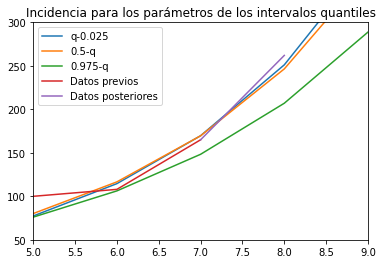

In [273]:
etiquetas=["q-0.025","0.5-q","0.975-q"]
t_start = 0.0; 
t_end = 10; 
t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)
Ydat=np.zeros(Num_semanas)
for fecha in datos['FECHA_SINTOMAS']:
    for k in range(1,len(Ydat)+1):#Esto se puede optimizar.
        if(fecha<vec_semanas[k] and fecha>=vec_semanas[k-1]):
            Ydat[k-1]+=1 
            break;
Ydat_prev=Ydat[:8]
Ydat_post=Ydat[:10]
for i in range(3):
    print(estimadores[i])
    def g(t,ps):
        SOL = spi.odeint(SIR,[6e6-1,1,1,0],t_range,args=(ps,))
        return np.diff(SOL[:,2])
    plt.plot(g(np.arange(0,8,500),[estimadores[i,0],estimadores[i,1],6e6]),label=etiquetas[i])
plt.plot(Ydat_prev,label='Datos previos')
plt.plot(np.arange(7,9,1),Ydat_post[7:-1],label='Datos posteriores')
plt.title('Incidencia para los parámetros de los intervalos quantiles')
plt.legend()
plt.xlim((5,9))
plt.ylim((50,300))
plt.show()